# Задание №1

### Сгенерируйте датасет со случайными нормально распределенными величинами $x_1$ и $x_2$ , $corr(x_1, x_2)=0.0$, $corr(x_1, x_3)=0.0$, $corr(x_2, x_3)=0.8$, размер выборки $N = 1000$ 

$ y = \beta_0 + \beta_1x_1 + \beta_2x_2 +  \beta_3x_3 + \epsilon$                                                                                    
Проведите симуляцию выборки для данной задачи на 10 тысячах итерациях. Итеративно сохраняйте нужные результаты модели и:

 1) Проверьте утверждение, что "Коэффициент модели  $\beta_1$ примерно в 95% итераций попадает в доверительные интервалы коэффициента  $\hat{\beta_1x_1}$ при уровне значимости 5%".
 
  2) В какой доле итераций коэффициенты модели $\beta_2x_2$ и  $\beta_3x_3$ попадают в доверительные интервалы своих оценок при уровне значимости 5%?

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit, Logit
from scipy import stats
import scipy as sci
from tqdm import tqdm
from utils4 import * 

In [179]:
dist_params = dict(

    # Зададим параметры распределения факторов
    x1_mean = 15.0,
    x1_std = 5.5,
    x2_mean = 10.0,
    x2_std = 4.0,
    x3_mean = 8.0,
    x3_std = 3.0,
    
    # Зададим параметры распределения ошибки
    e_mean = 0.0,
    e_std = 2.0,
    
    # Зададим параметры корреляции факторов
    corr_12 = 0.0,
    corr_13 = 0.0,
    corr_23 = 0.8,

    # Укажем размер выборки
    N = 1000,

    # Зададим действительные параметры модели
    beta0 = 78.0,
    beta1 = 6.8,
    beta2 = 1.2,
    beta3 = 14.1
    # beta0 = 1.5,
    # beta1 = 0.5,
    # beta2 = -0.3,
    # beta3 = 0.7
)

RANDOM_SEED = 42

In [180]:
iterations = 10000

# Для хранения результатов
beta_1_in_interval = 0
beta_2_in_interval = 0
beta_3_in_interval = 0

for _ in tqdm(range(iterations)):
    x_1 = np.random.normal(dist_params['x1_mean'], dist_params['x1_std'], dist_params['N'])
    x_2 = np.random.normal(dist_params['x2_mean'], dist_params['x1_std'], dist_params['N'])

    # Генерация x_3, коррелированной с x_2
    mu, sigma = dist_params['x3_mean'], dist_params['x3_std']  # среднее и стандартное отклонение
    A = np.array([[1, 0], [0.8, np.sqrt(1 - 0.8**2)]])
    x_2x_3 = np.dot(np.random.normal(mu, sigma, (dist_params['N'], 2)), A.T)
    x_3 = x_2x_3[:, 1]  # второй столбец - это x_3, коррелированная с x_2

    # Генерация ошибок
    epsilon = np.random.normal(0, 1, dist_params['N'])
    
    # Генерация y
    y = dist_params['beta0'] + dist_params['beta1']*x_1 + dist_params['beta2']*x_2 + dist_params['beta3']*x_3 + epsilon

    # Оценка модели
    X = np.column_stack((x_1, x_2, x_3))
    X = sm.add_constant(X)  # добавляем константу
    model = sm.OLS(y, X).fit()

    # Получение доверительных интервалов
    conf_intervals = model.conf_int(0.05)
    
    # Проверка попадания истинных значений в интервалы
    if conf_intervals[1, 0] < dist_params['beta1'] < conf_intervals[1, 1]:
        beta_1_in_interval += 1
    if conf_intervals[2, 0] < dist_params['beta2'] < conf_intervals[2, 1]:
        beta_2_in_interval += 1
    if conf_intervals[3, 0] < dist_params['beta3'] < conf_intervals[3, 1]:
        beta_3_in_interval += 1

# Результаты
print(f"Доля итераций, где beta_1 в доверительном интервале: {beta_1_in_interval/iterations:.3f}")
print(f"Доля итераций, где beta_2 в доверительном интервале: {beta_2_in_interval/iterations:.3f}")
print(f"Доля итераций, где beta_3 в доверительном интервале: {beta_3_in_interval/iterations:.3f}")


100%|██████████| 10000/10000 [00:11<00:00, 842.04it/s]

Доля итераций, где beta_1 в доверительном интервале: 0.948
Доля итераций, где beta_2 в доверительном интервале: 0.951
Доля итераций, где beta_3 в доверительном интервале: 0.950



#### $\bullet$ Утверждение, что "Коэффициент модели  $\beta_1$ примерно в 95% итераций попадает в доверительные интервалы коэффициента  $\hat{\beta_1x_1}$ при уровне значимости 5% $ \large верно $.
 
#### $\bullet$ Доля итераций в которых коэффициенты модели $\beta_2x_2$ и  $\beta_3x_3$ попадают в доверительные интервалы своих оценок при уровне значимости 5% = $ \large 0.95 $.

# Задание №2 

1. Обучите модель логистической регрессии на данных на всех факторах. Подготовьте Classification report, Confusion matrix, график распределения плотностеи предсказанных скоров модели по классам 0 и 1

In [181]:
heart_deaseases_dt = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [182]:
heart_deaseases_dt

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [183]:
heart_deaseases_dt.columns

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

d:\Users\nik_p\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.841

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84    229787
         1.0       0.24      0.80      0.37     23893

    accuracy                           0.74    253680
   macro avg       0.61      0.77      0.60    253680
weighted avg       0.90      0.74      0.79    253680



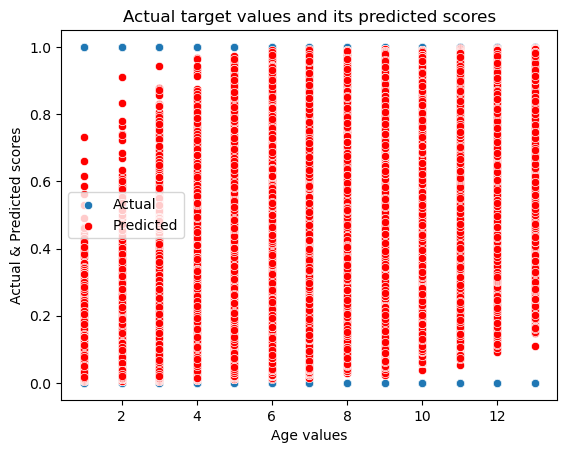

d:\Users\nik_p\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


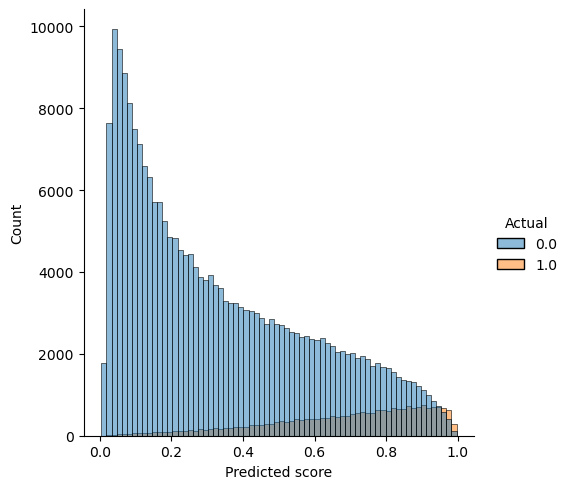

Predicted,0.000000,1.000000
Actual,,
0.000000,169233,60554
1.000000,4895,18998


In [184]:
heart_deaseases_dt = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
dt_logit, model_logit = train_binary(
    heart_deaseases_dt, target='HeartDiseaseorAttack',
    feature_names=list(heart_deaseases_dt.drop('HeartDiseaseorAttack', axis=1)),
    plot_feature='Age',
    model_type='logit', pkg='sklearn', class_weight='balanced')

2. Дайте комментарии по полученным результатам.

### $\bullet$ **Precision** (точность) - отношение TP к TP + FP. Это доля объектов, названными классификатором положительными и при этом действительно являющимися положительными. 
#### В нашем случае **precision = 0.24**. Это говорит о том, что классиффикатор не очень надежен в распознавании положительных меток.

### $\bullet$ **Recall** (Полнота) - отношение TP к TP + FN. Это то, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм.
#### В нашем случае **recall = 0.80**. Это говорит о том, что классиффикатор корректно распознает 80% положительных меток.

### $\bullet$ **F1-мера** – среднее гармоническое точности и полноты.
#### В нашем случае **F1-macro = 0.60**. Это значение выше, чем в ноутбуке с лекции. Это говорит о том, что модель обученная на большем числе факторов, является более предпочтительной.

### $\bullet$ **ROC-AUC** - это метрика равная площади под ROC-кривой. ROC-кривая это отношение TPR = TP / (TP + FN) к FPR = FP / (FP + TN).
#### **ROC-AUC** нашей модели равен **0.841**, что говорит о хорошем качестве классификации модели.

3.  Если бы за 1 месяц к вам на осмотр пришло 100 человек и вы ставили диагноз «склонность к сердечным болезням» только по модели, то в среднем скольким из них вы бы поставили диагноз корректно, ошибочно, скольких потенциальных больных упустили? Как вы считаете, насколько полученная вами модель хороша для применения на практике для
определения склонных к заболеваниям пациентов?

### Проанализируем результаты модели классификации:

#### $\bullet$ Precision (точность) равна 0.24, что означает, что из всех, кого модель определила как склонных к сердечным болезням, только 24% действительно склонны к этому заболеванию.

#### $\bullet$ Recall (полнота) равен 0.80, что говорит о том, что модель способна обнаружить 80% всех пациентов, склонных к сердечным болезням.

#### $\bullet$ F1-macro равен 0.60, что является средним гармоническим между precision и recall и позволяет оценить баланс между ними.

#### $\bullet$ ROC-AUC равен 0.841, что является хорошим показателем для бинарной классификации и указывает на хорошую разделяющую способность модели.

### Теперь рассмотрим практическое применение модели:

#### $\bullet$ Количество верно поставленных диагнозов: 80 (по recall).

#### $\bullet$ Количество ошибочных диагнозов: 100 - 80 = 20.

#### $\bullet$ Количество упущенных больных: 100 - 80 = 20.

### Модель имеет неплохую способность обнаруживать пациентов, склонных к сердечным болезням (**Recall = 0.80**), что является важным критерием для подобных моделей. Однако точность (**Precision = 0.24**) оставляет желать лучшего, это может привести к большому количеству ложноположительных диагнозов, что может повлечь за собой дополнительные исследования.